<a href="https://colab.research.google.com/github/hsieh8835/seasonal-forecast/blob/master/%E8%AB%96%E6%96%87TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import xarray as xr
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file = ['lfpw6', 'lfpw7', 'cmcc3', 'dwd2', 'ukmo13','ec1']
system = {}
for f in file:
    ds = xr.open_dataarray(f'/content/drive/MyDrive/nc/{f}.nc')
    ds = ds.astype('float32')
    system.setdefault(f,ds)
    del ds

In [4]:
obs = xr.open_dataarray('/content/drive/MyDrive/nc/obs1.nc')
obs = obs.astype('float32')
obs = obs.sel(time=slice('1995-01','2014-12'))

In [5]:
t2m = xr.concat((system['lfpw6'],system['lfpw7'],system['cmcc3'],system['dwd2'],system['ukmo13'],system['ec1']),dim='sys',coords='minimal', join='override',compat='override')

In [6]:
del system

In [7]:
step={}
for leadtime in range(6):
    data = t2m.isel(time=slice(12-leadtime,252-leadtime),step=leadtime)
    step.setdefault(f'{leadtime+1}',data)

In [8]:
t2m = xr.concat((step['1'],step['2'],step['3'],step['4'],step['5'],step['6']),dim='step', join='override')

In [9]:
del step

In [10]:
t2m = t2m.transpose('sys','time','step','latitude','longitude')

In [11]:
obs = obs.sel(time=slice('1995-01','2014-12'),latitude=slice(30,-30))

In [12]:
t2m = t2m.sel(latitude=slice(30,-30))

In [13]:
latitude = t2m.latitude
longitude = t2m.longitude
step = t2m.step 
sys = list(range(len(file)))
time = t2m.sel(time=slice('1996-01','2014-12')).time

In [14]:
t2m = t2m.data
obs = obs.data[np.newaxis,:,np.newaxis,:,:]

In [15]:
calibrate_data = np.ones((1,228,6,60,360))

In [16]:
print(t2m.shape)
print(obs.shape)

(6, 240, 6, 60, 360)
(1, 240, 1, 60, 360)


In [26]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

model = LinearRegression()
poly_model = PolynomialFeatures(degree=2, include_bias=False)
for i in range(19):  #19
    t2m_traindata =  np.delete(t2m,list(range((i * 12),(12 * i) + 24)),axis=1)
    obs_traindata =  np.delete(obs,list(range((i * 12),(12 * i) + 24)),axis=1)

    t2m_testdata = t2m[:,(i * 12):(12 * i) + 24,:]
    obs_testdata = obs[:,(i * 12):(12 * i) + 24,:]
    for leadtime in range(6):  #6
        for lat in range(60):  #60
            for lon in range(360):  #360
#=================PREDICTORS=============================================
              test_newvar = (obs_testdata[:,11-leadtime:-leadtime-1,0,lat,lon]+100) / (t2m_testdata[:,11-leadtime:-leadtime-1,leadtime,lat,lon]+100)
#=================PREDICTAND=============================================
              test_t2mdata = t2m_testdata[:,12:,leadtime,lat,lon]+100
#========================================================================
              train_newvar = (obs_traindata[:,:,0,lat,lon]+100) / (t2m_traindata[:,:,leadtime,lat,lon]+100)
#========================================================================
              if i==0 or i==19:
                train_newvar_mean = train_newvar.mean(axis=1)
                train_newvar_cycm = (train_newvar-train_newvar_mean[:,np.newaxis]).reshape(t2m.shape[0],18,12).mean(axis=1)
                MM = train_newvar_mean[:,np.newaxis]+train_newvar_cycm
                new_var = train_newvar - np.tile(MM,(1,18))
                n=1
                pca = PCA(n_components=n)
                u = pca.fit_transform(new_var)
                X = new_var[:,:-1-leadtime]
                Y = new_var[:,leadtime+1:]
              else:
                train_newvar_mean = train_newvar.mean(axis=1)
                train_newvar_cycm = (train_newvar-train_newvar_mean[:,np.newaxis]).reshape(t2m.shape[0],18,12).mean(axis=1)
                MM = train_newvar_mean[:,np.newaxis]+train_newvar_cycm
                new_var = train_newvar - np.tile(MM,(1,18))
                n=1
                pca = PCA(n_components=n)
                u = pca.fit_transform(new_var)
                before_predictor = new_var[:,0:(i * 12) - leadtime - 1]
                after_predictor = new_var[:,(i * 12):-leadtime - 1]
                before_predictand = new_var[:,0 + leadtime + 1:(i * 12)]
                after_predictand = new_var[:,(i * 12) + leadtime + 1:]
                X = np.concatenate((before_predictor,after_predictor),axis=1)
                Y = np.concatenate((before_predictand,after_predictand),axis=1)
#====================================================================================
              predictor_PCs = u.T.dot(X)
              predicttand_PCs = u.T.dot(Y)
              validation_predoctor = test_newvar - MM
              validation_predoctor_PCs = u.T.dot(validation_predoctor)
              model.fit(predictor_PCs.T, predicttand_PCs.T)
              newvar_guess = model.predict(validation_predoctor_PCs.T)
              newvar_guess1 = u[:,:n].dot(newvar_guess.T) + MM
              obs_pred = newvar_guess1 * (test_t2mdata)
              pred = obs_pred - 100
              calibrate_data[:,i*12:(i*12)+12,leadtime,lat,lon] = pred.mean(axis=0).T

In [27]:
Polynomial = xr.DataArray(calibrate_data,coords=[[1],time,step,latitude,longitude],dims=['sys','time','step','latitude','longitude'])

In [28]:
Polynomial.to_netcdf('Polynomial.nc')

In [29]:
del calibrate_data

In [30]:
ds = xr.open_dataarray('Polynomial.nc')

In [31]:
ds = ds.mean(dim='sys')

In [51]:
obs = xr.open_dataarray('/content/drive/MyDrive/nc/obs1.nc')
obs = obs.astype('float32')

In [71]:
obs=obs.sel(time=slice('1996-01','2014-12'),latitude=slice(30,-30))

In [35]:
corr = xr.corr(ds,obs,dim='time')

In [39]:
calibrate_data = ds.data
obs1 = obs.data

In [42]:
rmse = np.zeros((6,60,360))
for leadtime in range(6):
    for lat in range(60):
        for lon in range(360):           
            r1 = np.sqrt(mean_squared_error(obs1[:,lat,lon], calibrate_data[:,leadtime,lat,lon]))   #計算觀測值與修正值的RMSE
            std = np.std(obs1[:,lat,lon])    #計算觀測值的標準差
            rmse[leadtime, lat, lon] = r1 / std    #將RMSE標準化

In [43]:
rmse = xr.DataArray(rmse,coords=[step,latitude,longitude],dims=['step','latitude','longitude'])

In [45]:
!pip install cartopy

     |████████████████████████████████| 12.1 MB 7.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 57.7 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516254 sha256=e6501510733743bc56e94fe12ad73c05c996c9f7413bde383a923c583d30a642
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=892bc3b58afe4218111f6e4d343f39e586b9dce7010d18038cc5ab97ccf4b405
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built cartopy pyshp


In [46]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


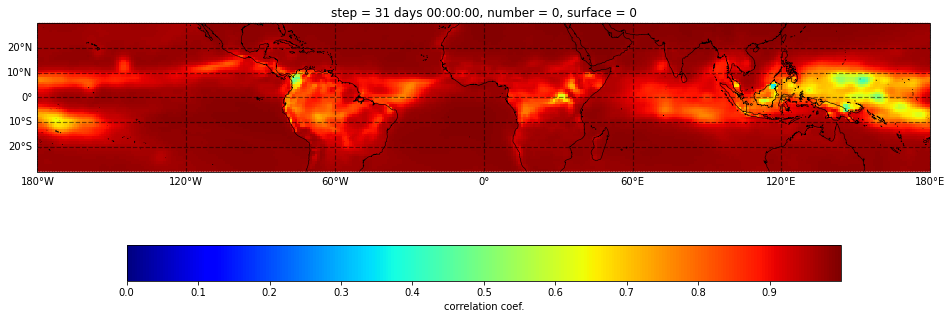

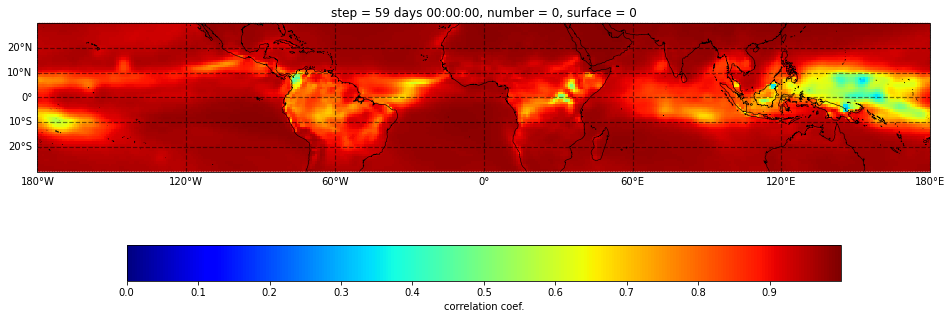

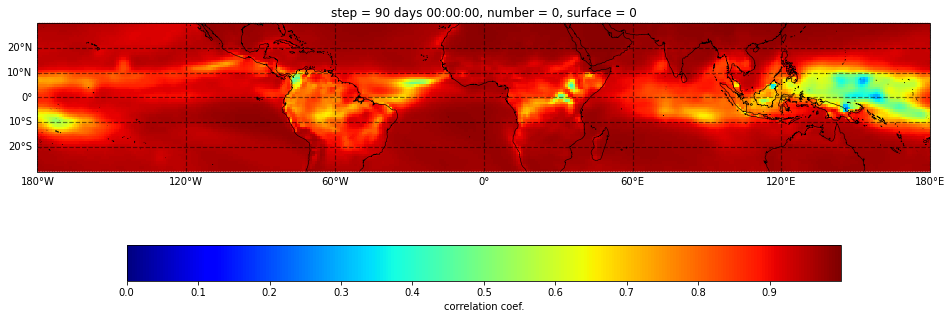

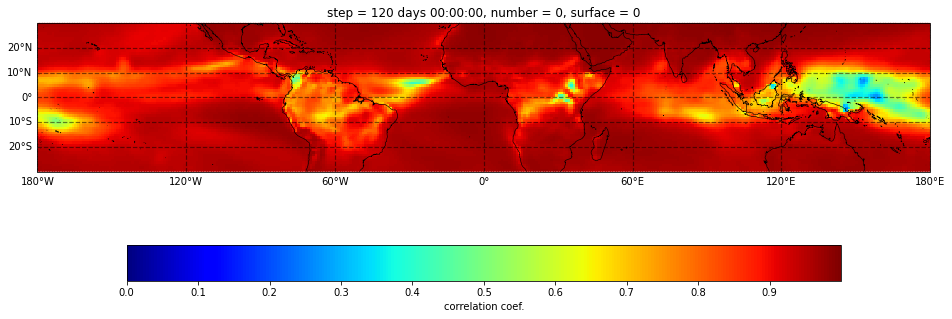

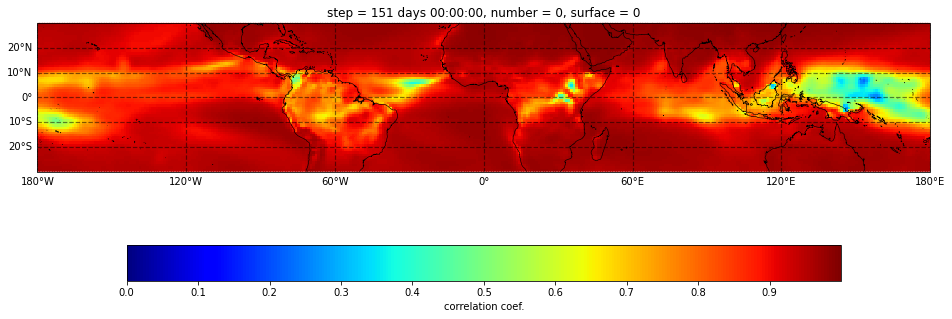

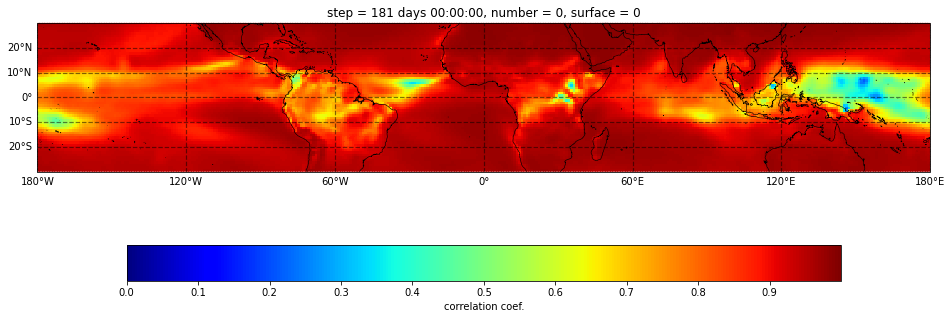

In [47]:
cbar_kwargs = {'label': 'correlation coef.','shrink':0.8,'ticks': np.arange(0,1,.1 ),'orientation':'horizontal'}
for i in range(6):

    # 創建畫圖空間
    proj = ccrs.PlateCarree() #創建投影
    fig = plt.figure(figsize=(16,9)) #創建頁面
    ax = fig.subplots(1, 1, subplot_kw={'projection': proj}) #子圖

    ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=1)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False #關閉頂端標籤
    gl.ylabels_right = False #關閉右側標籤
    gl.xformatter = LONGITUDE_FORMATTER #X軸設為經度格式
    gl.yformatter = LATITUDE_FORMATTER #Y軸設為緯度格式


    corr.isel(step=i).plot(cmap=plt.cm.jet,
                           cbar_kwargs=cbar_kwargs,
                           transform=ccrs.PlateCarree(),
                           vmin=0,
                           vmax=1,
                           ) #也可以用Size=?設定圖片大小 robust=True改善離群值
    plt.show()

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


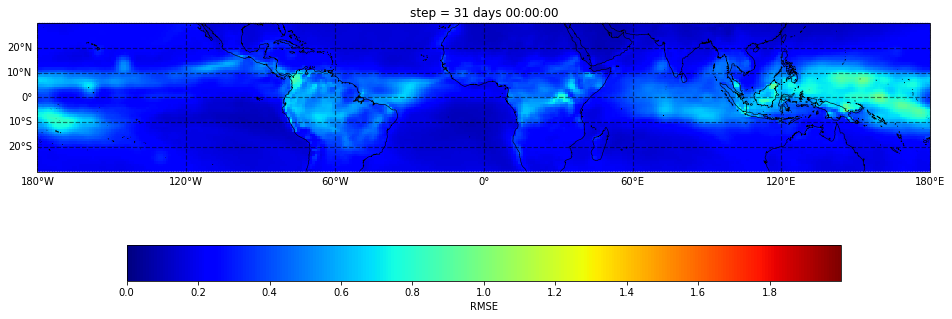

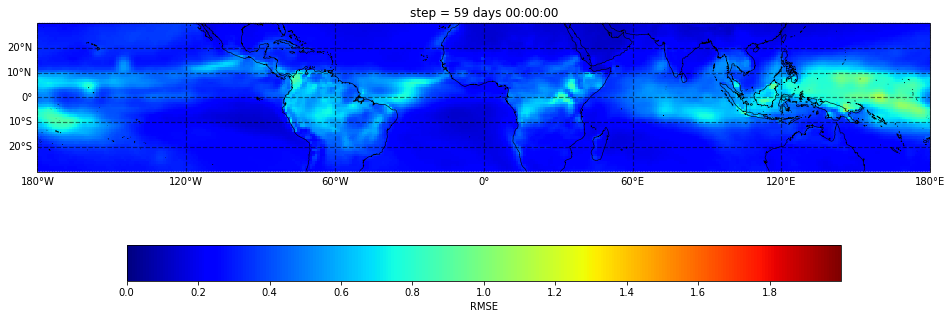

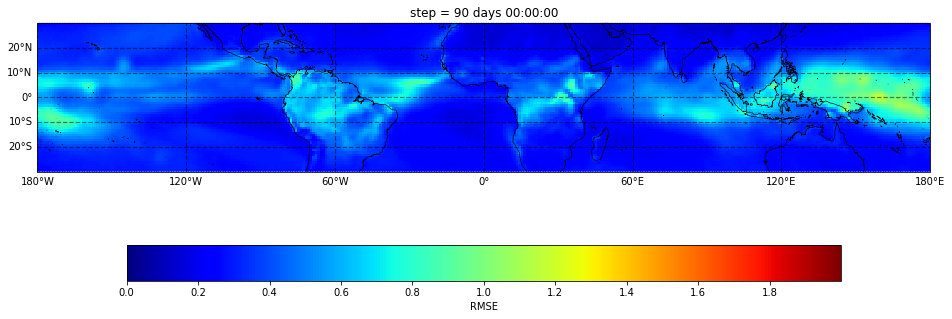

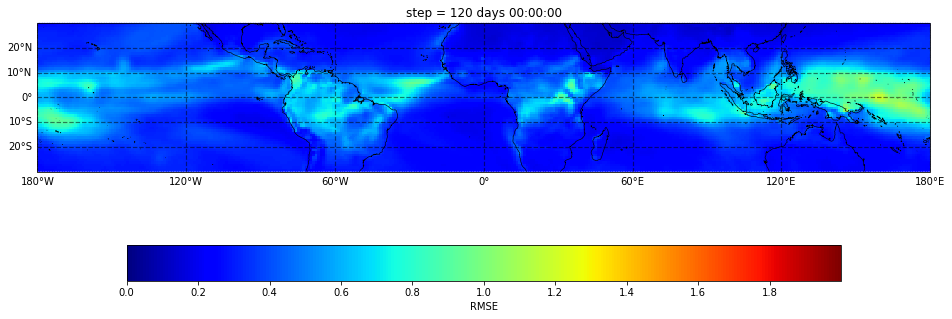

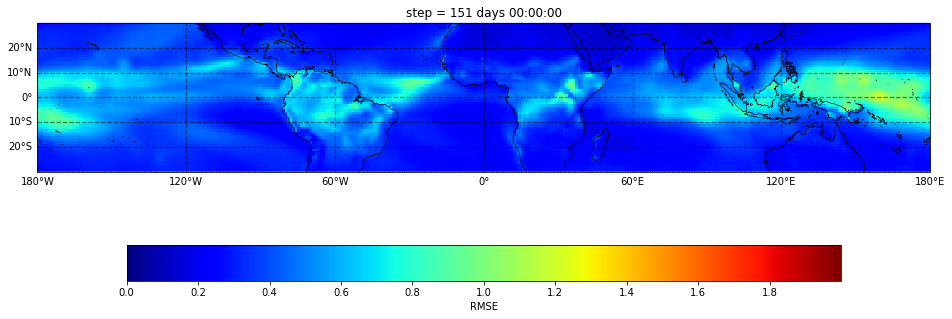

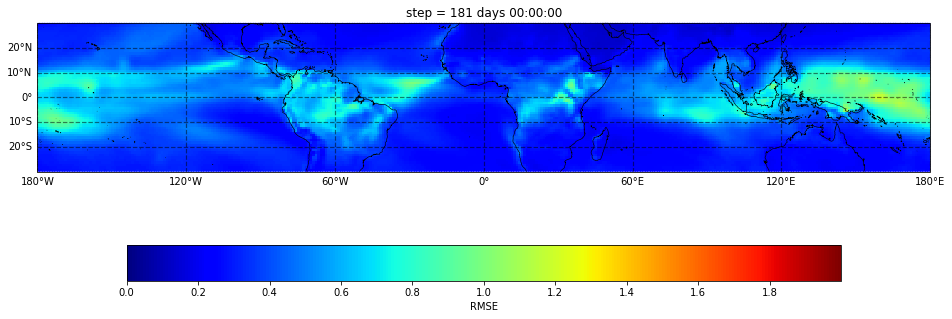

In [48]:
cbar_kwargs = {'label': 'RMSE','shrink':0.8,'ticks': np.arange(0,2,.2 ),'orientation':'horizontal'}
for i in range(6):

    # 創建畫圖空間
    proj = ccrs.PlateCarree() #創建投影
    fig = plt.figure(figsize=(16,9)) #創建頁面
    ax = fig.subplots(1, 1, subplot_kw={'projection': proj}) #子圖

    ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=1)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False #關閉頂端標籤
    gl.ylabels_right = False #關閉右側標籤
    gl.xformatter = LONGITUDE_FORMATTER #X軸設為經度格式
    gl.yformatter = LATITUDE_FORMATTER #Y軸設為緯度格式


    rmse.isel(step=i).plot(cmap=plt.cm.jet,
                           cbar_kwargs=cbar_kwargs,
                           transform=ccrs.PlateCarree(),
                           vmin=0,
                           vmax=2
                           ) #也可以用Size=?設定圖片大小 robust=True改善離群值
    plt.show()

In [72]:
calibrate_data_gb = ds.groupby('time.month')
obs_gb = obs.groupby('time.month')

In [73]:
calibrate_data_anom = calibrate_data_gb - calibrate_data_gb.mean(dim='time')
obs_anom = obs_gb - obs_gb.mean(dim='time')

In [74]:
corr = xr.corr(calibrate_data_anom,obs_anom,dim='time')

In [75]:
calibrate_data_anom = calibrate_data_anom.data
obs_anom = obs_anom.data

In [78]:
rmse = np.zeros((6,60,360))
for leadtime in range(6):
    for lat in range(60):
        for lon in range(360):           
            r1 = np.sqrt(np.mean((calibrate_data_anom[:,leadtime,lat,lon] - obs_anom[:,lat,lon])**2))
            std = np.std(obs_anom[:,lat,lon])
            rmse[leadtime, lat, lon] = r1 / std

In [79]:
rmse = xr.DataArray(rmse,coords=[step,latitude,longitude],dims=['step','latitude','longitude'])

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


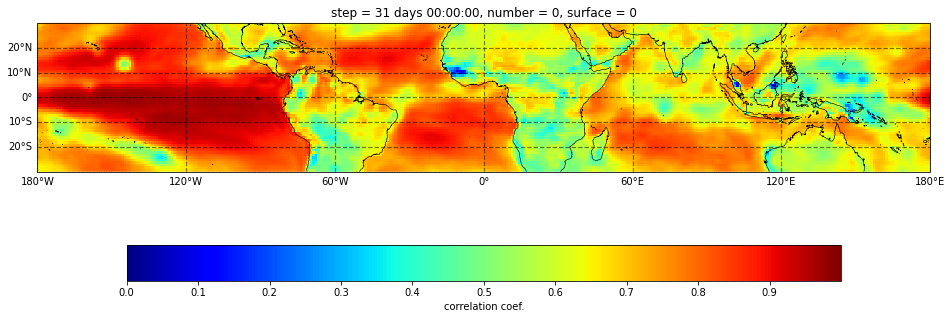

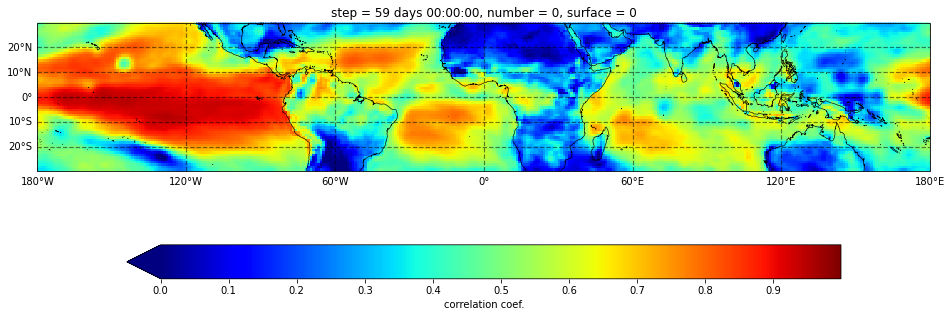

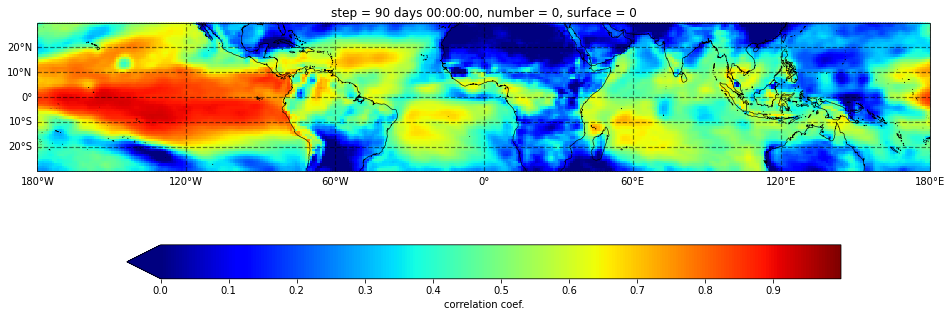

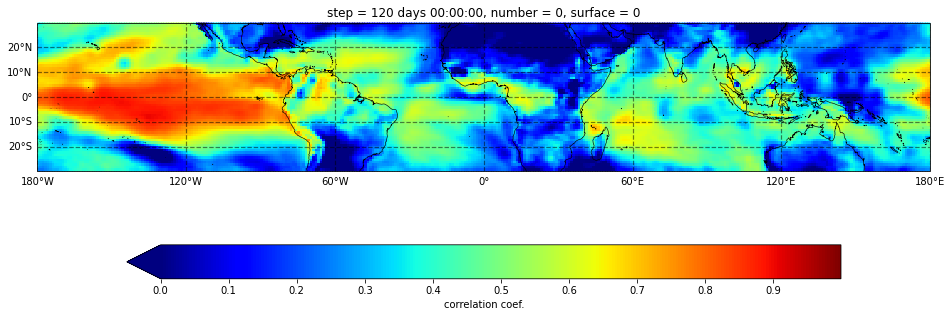

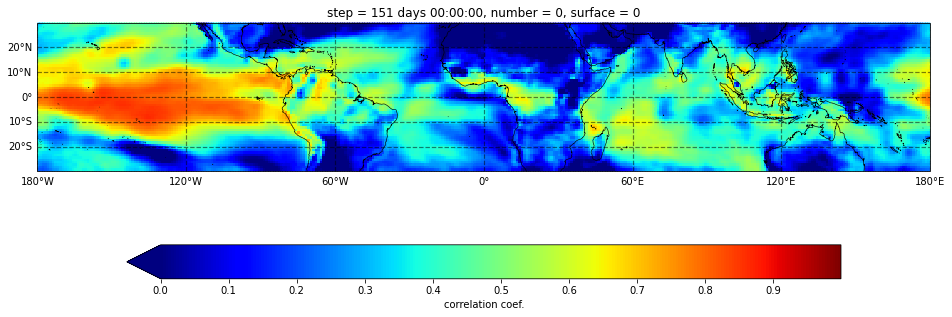

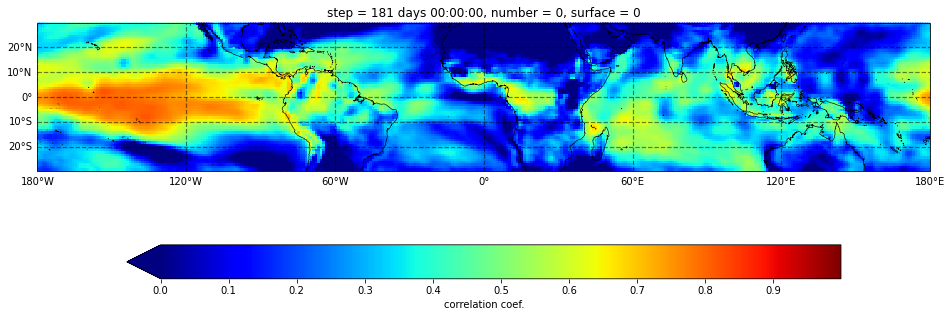

In [80]:
cbar_kwargs = {'label': 'correlation coef.','shrink':0.8,'ticks': np.arange(0,1,.1 ),'orientation':'horizontal'}
for i in range(6):

    # 創建畫圖空間
    proj = ccrs.PlateCarree() #創建投影
    fig = plt.figure(figsize=(16,9)) #創建頁面
    ax = fig.subplots(1, 1, subplot_kw={'projection': proj}) #子圖

    ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=1)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False #關閉頂端標籤
    gl.ylabels_right = False #關閉右側標籤
    gl.xformatter = LONGITUDE_FORMATTER #X軸設為經度格式
    gl.yformatter = LATITUDE_FORMATTER #Y軸設為緯度格式


    corr.isel(step=i).plot(cmap=plt.cm.jet,
                           cbar_kwargs=cbar_kwargs,
                           transform=ccrs.PlateCarree(),
                           vmin=0,
                           vmax=1
                           ) #也可以用Size=?設定圖片大小 robust=True改善離群值
    plt.show()

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


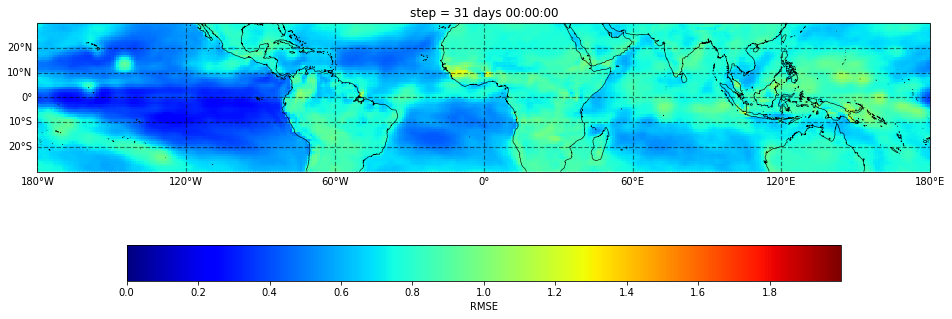

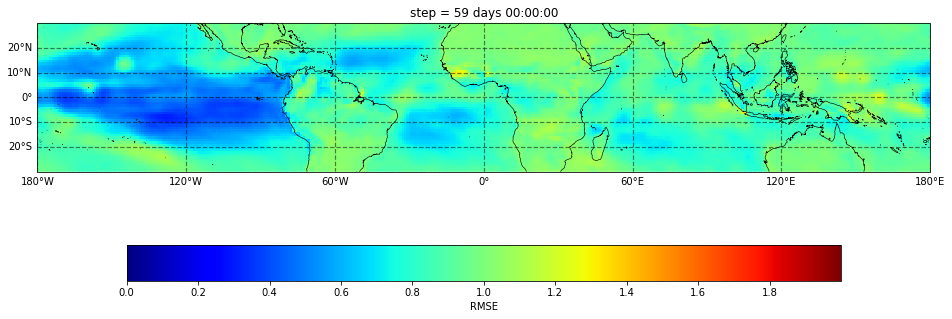

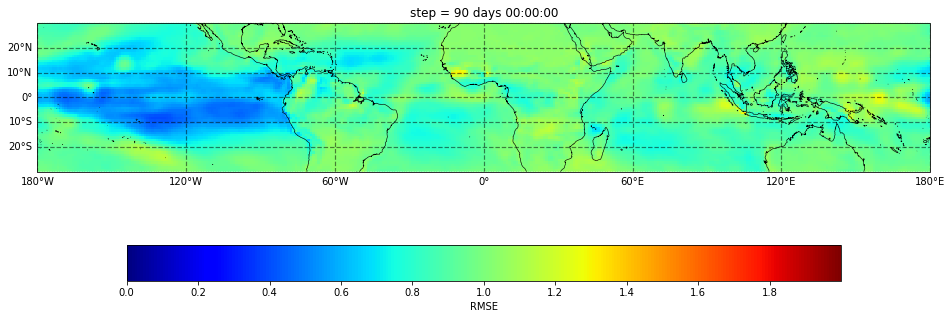

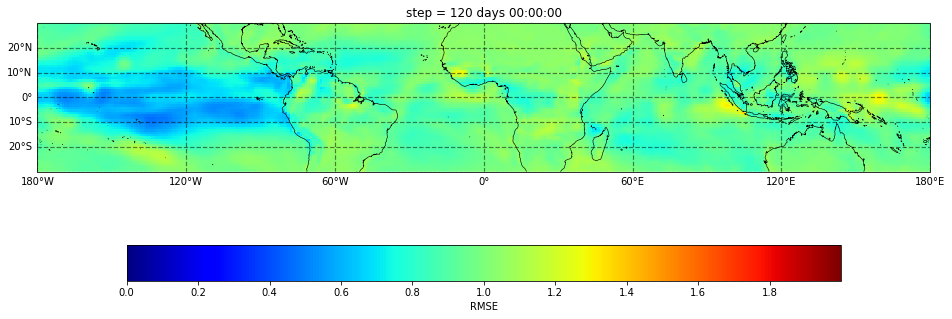

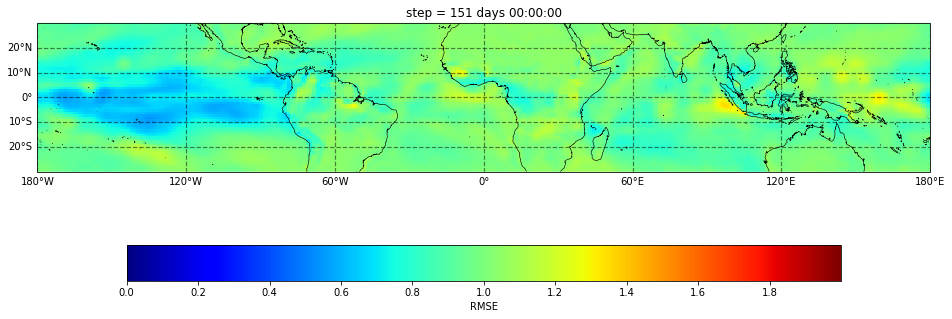

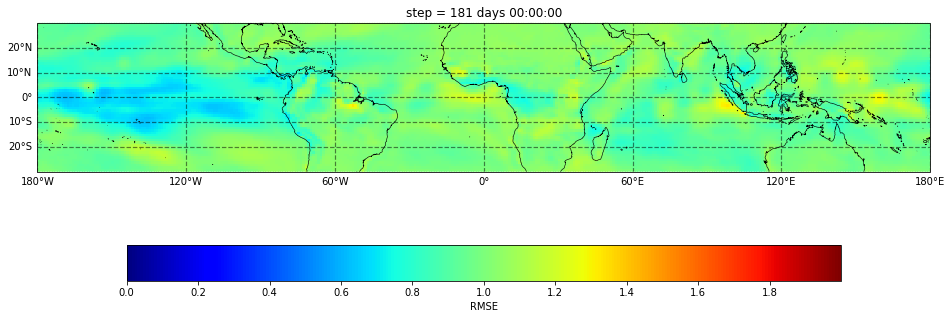

In [81]:
cbar_kwargs = {'label': 'RMSE','shrink':0.8,'ticks': np.arange(0,2,.2 ),'orientation':'horizontal'}
for i in range(6):

    # 創建畫圖空間
    proj = ccrs.PlateCarree() #創建投影
    fig = plt.figure(figsize=(16,9)) #創建頁面
    ax = fig.subplots(1, 1, subplot_kw={'projection': proj}) #子圖

    ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=1)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    gl.xlabels_top = False #關閉頂端標籤
    gl.ylabels_right = False #關閉右側標籤
    gl.xformatter = LONGITUDE_FORMATTER #X軸設為經度格式
    gl.yformatter = LATITUDE_FORMATTER #Y軸設為緯度格式


    rmse.isel(step=i).plot(cmap=plt.cm.jet,
                           cbar_kwargs=cbar_kwargs,
                           transform=ccrs.PlateCarree(),
                           vmin=0,
                           vmax=2
                           ) #也可以用Size=?設定圖片大小 robust=True改善離群值
    plt.show()